<a href="https://colab.research.google.com/github/jkauf8/liver_segmentation/blob/main/Deep_Learning_Liver_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Purpose of this Code is to Utilize a U-Net Deep Learning Model to Automatically Segment Livers

Slides for the data, the annotations, the prepocessing, the network structure, loss function, training results, and testing results 

In [1]:
import sys
!{sys.executable} -m pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.6 MB/s eta 0:00:00


In [2]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2
from keras.utils import normalize
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import nibabel as nib
import re
import pydicom as dicom
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose, BatchNormalization, Activation, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.models import Model
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from sklearn.metrics import f1_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read in liver masks

In [4]:
directory = '/content/drive/My Drive/Radiology Research/masks'
masks=[]
for filename in sorted(os.listdir(directory)):
  for files in sorted((os.listdir(os.path.join(directory, filename)))):
    file=os.path.join(directory, filename, files)
    image=nib.load(file).get_fdata()
    scaled_image = np.rot90(np.fliplr(np.uint8(image)))
    masks.append(scaled_image)

In [5]:
print(len(masks))
print(masks[1].shape)
print(len(masks[1]))

42
(176, 256, 120)
176


In [6]:
temp=masks

In [7]:
new=[]
for i in range(len(temp)):
  for j in range(temp[i].shape[2]):
    new.append(temp[i][:,:,j])

Read in dicom images

In [8]:
images=[]
final_images=[]
directory2 = '/content/drive/My Drive/Radiology Research/images'
for filename in sorted(os.listdir(directory2)):
  for files in sorted(int(i) for i in (os.listdir(os.path.join(directory2, filename)))):
    for image in sorted(os.listdir(os.path.join(directory2,filename,str(files))),reverse=True):
      if image.endswith('.dcm'):
          ds = dicom.dcmread(os.path.join(directory2, filename, str(files), image))
          image=ds.pixel_array.astype(float)
          scaled_image = (np.maximum(image, 0) / image.max()) * 255.0
          scaled_image = np.uint8(scaled_image)
          #final_image = Image.fromarray(scaled_image)
          images.append(scaled_image)
    final_images.append(images)
    images=[]

In [9]:
len(final_images)

42

In [10]:
final_images[1][1].shape

(176, 256)

In [11]:
len(final_images[0])

120

Normalize image values

In [12]:
for i in range(len(final_images)):
  for j in range(len(final_images[i])):
    final_images[i][j]=cv2.normalize(final_images[i][j], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

Example Image

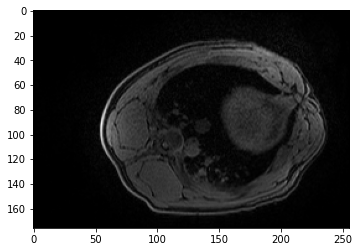

In [13]:
test = final_images[0][100] #second index is slice number 
plt.imshow(test, cmap="gray")
plt.show()

Example Mask

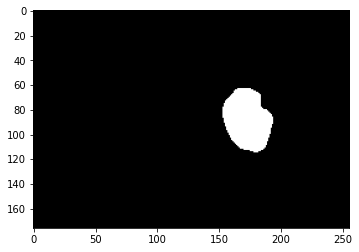

In [14]:
test = masks[0][:,:,100]
plt.imshow(test, cmap="gray")
plt.show()

In [15]:

def conv_block(input, num_filters):
  #add BatchNormalization and Activation layers 
  x=Conv2D(num_filters, 3, padding='same')(input)
  x=BatchNormalization(x)
  x=Dropout(0.2)(x)
  x=Activation('relu')
  x=Conv2D(num_filters, 3, padding='same')(input)
  x=Dropout(0.2)(x)
  x=BatchNormalization(x)
  x=Activation('relu')

  return x


In [16]:
def encoder_block(input, num_filters):
  x=conv_block(input, num_filters)
  p=MaxPool2D((2,2))(x)
  return x,p

In [17]:
def decoder_block(input, skip_features, num_filters):
  x=Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(input)
  x=Concatenate()([x, skip_features])
  x=conv_block(x,num_filters)
  return x

In [18]:
def unet(input_shape):
  #start with 16 filters
  inputs=Input(input_shape)
  s1, p1 = encoder_block(inputs, 16)
  s2, p2 = encoder_block(p1, 32)
  s3, p3 = encoder_block(p2, 64)
  s4, p4 = encoder_block(p3, 128)

  b1 = conv_block(p4, 256) 

  d1 = decoder_block(b1, s4, 128)
  d2 = decoder_block(d1, s3, 64)
  d3 = decoder_block(d2, s2, 32)
  d4 = decoder_block(d3, s1, 16)

  outputs = Conv2D(1,1, padding='same', activation='sigmoid')(d4)

  model=Model(inputs, outputs, name='UNET')
  return model

Define image dimensions

In [19]:
IMG_WIDTH=256 #176 original (should we do 128x128)
IMG_HEIGHT=176 #256 original
IMG_CHANNELS = 1

In [20]:
# add callbacks, model checkpoint
# crop first then downsample 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(final_images, masks, test_size=0.20, random_state=42) # check for class imbalance 
# potenitally remove masks that are blank 

In [22]:
'''
function to unravel the images contained in multidimensional list and place them in one-dimensional list 
'''

def unravel_image_list(lister):
  new=[]
  for i in range(len(lister)):
    for j in range(len(lister[i])):
      new.append(lister[i][j])

  return new 

In [23]:
def unravel_mask_list(lister):
  new=[]
  for i in range(len(lister)):
    for j in range(lister[i].shape[2]):
      new.append(lister[i][:,:,j])

  return new 

In [24]:
X_train=unravel_image_list(X_train)
X_test=unravel_image_list(X_test)

y_train=unravel_mask_list(y_train)
y_test=unravel_mask_list(y_test)

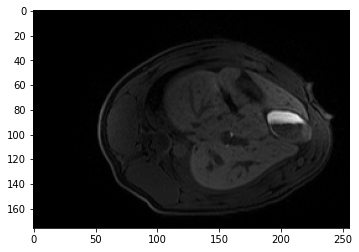

In [25]:
test = X_train[80]
plt.imshow(test, cmap="gray")
plt.show()

Resize Images

In [26]:
X_train2=[]
for i in X_train:
  X_train2.append(resize(i, (176, 256)))

X_test2=[]
for i in X_test:
  X_test2.append(resize(i, (176, 256)))


y_train2=[]
for i in y_train:
  y_train2.append(resize(i, (176, 256)))

y_test2=[]
for i in y_test:
  y_test2.append(resize(i, (176, 256)))

In [27]:
# dice index measures the overlap between manual and automatic segmentation 

In [28]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [29]:
tf.keras.utils.get_custom_objects()['dice_coef'] = dice_coef
tf.keras.utils.get_custom_objects()['dice_coef_loss'] = dice_coef_loss

In [30]:
class dice_coef_loss():
  def __init__(self):
    super().__init__()
  def dice_coef_loss(self, y_true, y_pred):
    return -dice_coef(y_true, y_pred)
  def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.keras.metrics.Sum()(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.metrics.Sum()(y_true_f) + tf.keras.metrics.Sum()(y_pred_f) + 1)


In [31]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

# try only using dropout at deepest layer 

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.BatchNormalization()(c1)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2=  tf.keras.layers.BatchNormalization()(c2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.BatchNormalization()(c3)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.BatchNormalization()(c4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.BatchNormalization()(c5)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.BatchNormalization()(c6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.BatchNormalization()(c7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.BatchNormalization()(c8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.BatchNormalization()(c9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adadelta', loss='dice_coef_loss', metrics=['dice_coef']) # f1 score, similarity coefficient, Adadelta optimizer, dice for metric and loss function 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 176, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 176, 256, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 176, 256, 16  160         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [32]:
# rule of thumb is # of data is 1/10 of trainable parameters

Convert image arrays to single array with the first dimension being the number of samples

In [33]:
X_train2 = np.stack(X_train2, axis=0)
X_test2 = np.stack(X_test2, axis=0)

y_train2 = np.stack(y_train2, axis=0)
y_test2 = np.stack(y_test2, axis=0)

Building the model

In [34]:
results = model.fit(X_train2, y_train2, validation_split=0.1, batch_size=8, epochs=100) #shuffle=True
#results = model.fit(X_train2, y_train2, validation_split=0.1, batch_size=16, epochs=25) # 100 to 150 epochs 

Epoch 1/100
444/444 [==============================] - 30s 24ms/step - loss: -3.9942e-04 - dice_coef: 3.9943e-04 - val_loss: -4.6263e-04 - val_dice_coef: 4.5702e-04
Epoch 2/100
444/444 [==============================] - 10s 22ms/step - loss: -4.0821e-04 - dice_coef: 4.0823e-04 - val_loss: -4.4144e-04 - val_dice_coef: 4.3613e-04
Epoch 3/100
444/444 [==============================] - 10s 22ms/step - loss: -4.1061e-04 - dice_coef: 4.1045e-04 - val_loss: -4.3019e-04 - val_dice_coef: 4.2502e-04
Epoch 4/100
444/444 [==============================] - 10s 22ms/step - loss: -4.1247e-04 - dice_coef: 4.1253e-04 - val_loss: -4.3268e-04 - val_dice_coef: 4.2748e-04
Epoch 5/100
444/444 [==============================] - 9s 21ms/step - loss: -4.1408e-04 - dice_coef: 4.1418e-04 - val_loss: -4.3461e-04 - val_dice_coef: 4.2938e-04
Epoch 6/100
444/444 [==============================] - 10s 22ms/step - loss: -4.1421e-04 - dice_coef: 4.1423e-04 - val_loss: -4.2935e-04 - val_dice_coef: 4.2418e-04
Epoch 7/100

Graph Loss

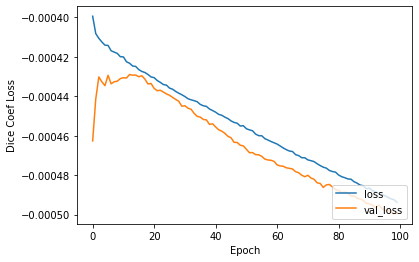

In [36]:
plt.plot(results.history['loss'], label='loss')
plt.plot(results.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Dice Coef Loss')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

Test the Model

In [37]:
 # score of model.predict(X_test2) -> y_test2

In [38]:
test_loss, test_dice_coef = model.evaluate(X_test2,  y_test2, verbose=2)

33/33 - 1s - loss: -5.2392e-04 - dice_coef: 5.2392e-04 - 806ms/epoch - 24ms/step


In [39]:
print(test_dice_coef)

0.0005239187739789486


EXTRAS

In [ ]:
# model=unet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 176, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_59 (Conv2D)             (None, 176, 256, 16  160         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_28 (Dropout)           (None, 176, 256, 16  0           ['conv2d_59[0][0]']              
                                )                                                              

In [ ]:
X_train, y_train, X_test, y_test = train_test_split(model_images, model_masks, test_size=0.33, random_state=42)

All masks in one dimensional list

In [ ]:
all_masks=[]
for i in range(len(masks)):
  for j in range((masks[i].shape)[2]):
    all_masks.append(masks[i][:,:,j])
print(len(all_masks))

5000


All dicom images in one dimensional list

In [ ]:
all_images=[]

for i in range(len(final_images)):
  for j in range(len(final_images[i])):
    all_images.append(final_images[i][j])
print(len(all_images))

5000


Resize all images (do we want to do this?)

In [ ]:
model_masks=[]
for i in all_masks:
  model_masks.append(resize(i, (128, 128)))

model_images=[]
for i in all_images:
  model_images.append(resize(i, (128, 128)))